## Tutorial 4
Solving the 1D unsteady diffusion equation using a Physics Informed Neural Network (PINN).  
The Equation is given by:
$$\frac {\partial u} {\partial t} - \mu \frac {\partial^2 u} {\partial x^2} = 0$$
The Domain for $x$ and $t$ are $x\in [0,1]$, and $t\in [0,1]$.  
The ICs/BSs are (here $T=1$):
$$u(x,t=0)=sin(\frac {2\pi x} {T})$$
$$u(x=0,t)=0$$
$$u(x=1,t)=0$$
$$u_x(x=0,t)=u_x(x=1,t)$$


In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
#whatsapp
#houwudoin
#hidsadsadsa
#ddgvsvcvvvvvdsadsadsadsaddsa
#dsadsadsdsa

### Define PINNs network class with Fourier Feature Mapping

In [3]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim, std_dev = 10):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(out_dim, in_dim) * std_dev) # Length of hidden layer is rows, 

    def forward(self, x):
        return torch.cos(F.F.linear(x, self.omega))

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=32, out_dim=3, activation=nn.Tanh()):
        """
        Parameters
        -------------
        in_dim: the input dimensions - number of independant variables
        HL_dim: the width of the network
        out_dim: the output dimensions - number of dependant variables
        activation: The activation function you wish to use in the network - the default is nn.Tanh()
        """
        super().__init__()
        
        # define the network architecture
        network = [nn.Linear(in_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        '''network = [ffm(in_dim, HL_dim),
                   nn.Linear(in_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]'''
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
    
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    
    
    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
        print(type(u))
        # u.requires_grad=True
        # v.requires_grad=True
        # p.requires_grad=True

        # compute PDE derivatives using auto grad
        # we need to specify the dimension of the output array
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_x_reshaped = u_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #v_x_reshaped = v_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_x_reshaped = u_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[Nx-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[Nx-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, Ny-1], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,Ny-1], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, 0], u_i * torch.ones_like(u_reshaped[:,0])) \
                + loss_fun(v_reshaped[:, 0], torch.zeros_like(v_reshaped[:,0])) \
        
    
        return pde_loss, bc_loss


### Define Model and Optimizer

In [4]:
model = PINNs_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [8]:
# num of points in the domain
Nx, Ny = 64, 64
u_i = 0.1 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)
for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j
print(type(x))
print(x.shape)

<class 'torch.Tensor'>
torch.Size([64, 64])


### Training the PINNs network

In [9]:
for epoch in range(300):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i)

    # compute total loss
    total_loss = eq_loss + 20*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"epoch: {epoch}, loss: {total_loss}")


<class 'torch.Tensor'>
epoch: 0, loss: 1671.0244140625
<class 'torch.Tensor'>
epoch: 1, loss: 1134.9195556640625
<class 'torch.Tensor'>
epoch: 2, loss: 468.6680603027344
<class 'torch.Tensor'>
epoch: 3, loss: 114.01536560058594
<class 'torch.Tensor'>
epoch: 4, loss: 26.148473739624023
<class 'torch.Tensor'>
epoch: 5, loss: 10.893411636352539
<class 'torch.Tensor'>
epoch: 6, loss: 8.717867851257324
<class 'torch.Tensor'>
epoch: 7, loss: 8.481788635253906
<class 'torch.Tensor'>
epoch: 8, loss: 8.178706169128418
<class 'torch.Tensor'>
epoch: 9, loss: 7.543591022491455
<class 'torch.Tensor'>
epoch: 10, loss: 6.688903331756592
<class 'torch.Tensor'>
epoch: 11, loss: 5.791845798492432
<class 'torch.Tensor'>
epoch: 12, loss: 4.996739387512207
<class 'torch.Tensor'>
epoch: 13, loss: 4.376223564147949
<class 'torch.Tensor'>
epoch: 14, loss: 3.9234509468078613
<class 'torch.Tensor'>
epoch: 15, loss: 3.5714375972747803
<class 'torch.Tensor'>
epoch: 16, loss: 3.2318472862243652
<class 'torch.Tenso

torch.Size([4096, 3])
u:  torch.Size([4096])
v:  torch.Size([4096])
x_np:  (4096, 4096)
x_np:  <class 'numpy.ndarray'>
x:  torch.Size([64, 64])
x:  <class 'torch.Tensor'>
u:  <class 'torch.Tensor'>
u_np:  (64, 64)
u_np:  <class 'numpy.ndarray'>
v max:  tensor(0.0367, grad_fn=<MaxBackward1>)
v_np max:  0.03669504
u max:  tensor(9.3344, grad_fn=<MaxBackward1>)
u_np max:  9.334372


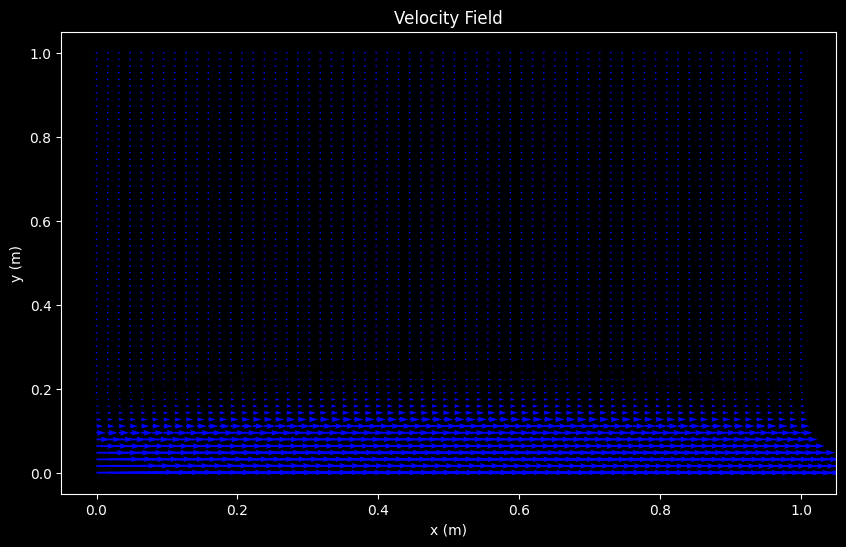

In [16]:
x_np, y_np = np.meshgrid(x, y)
net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
print(net.shape)
u=net[:, 0]
v=net[:, 1]
print("u: ",u.shape)
print("v: ",v.shape)

print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))

print("x: ",x.shape)
print("x: ",type(x))
print("u: ",type(u))

u_np = u.detach().numpy().reshape(Nx,Ny) # convert into a np array
print("u_np: ",u_np.shape)
print("u_np: ",type(u_np))

v_np = v.detach().numpy().reshape(Nx,Ny) # convert into a np array
print("v max: ", v.max())
print("v_np max: ", v_np.max())
print("u max: ", u.max())
print("u_np max: ", u_np.max())

plt.figure(figsize=(10, 6))
plt.quiver(x, y, u_np, v_np, color='blue')
plt.title("Velocity Field")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()
#plt.imshow(net_reshaped[:,:], cmap='jet')
# plt.title("Solution for $u(x,y)$ over time")
# plt.colorbar()
# plt.xlabel("y (m)")
# plt.ylabel("x (m)")
# plt.show()



x_np:  (64, 64)
x_np:  <class 'numpy.ndarray'>
u:  torch.Size([4096])
v:  torch.Size([4096])
x_np:  (64, 64)
x_np:  <class 'numpy.ndarray'>
x:  torch.Size([64, 64])
x:  <class 'torch.Tensor'>
u:  <class 'torch.Tensor'>


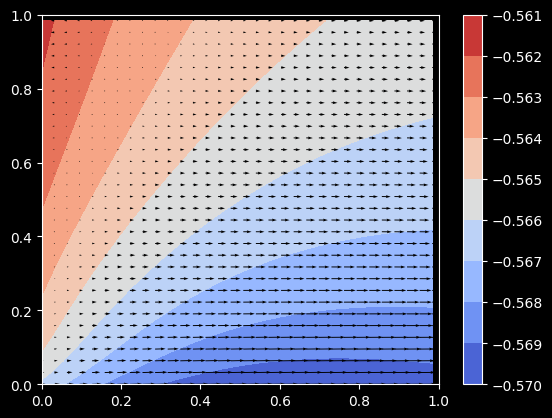

tensor(0.0213, grad_fn=<SelectBackward0>)


In [13]:
#  x_np, y_np = np.meshgrid(x, y)
x_np = x.detach().numpy()
y_np = y.detach().numpy()
print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))
net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]
print("u: ",u.shape)
print("v: ",v.shape)

print("x_np: ",x_np.shape)
print("x_np: ",type(x_np))

print("x: ",x.shape)
print("x: ",type(x))
print("u: ",type(u))

u_np = u.detach().numpy().reshape(Nx,Ny) # convert into a np array
v_np = v.detach().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().numpy().reshape(Nx,Ny) # convert into a np array

plt.style.use("dark_background")
plt.figure()
plt.contourf(x_np[::2, ::2], y_np[::2, ::2], p_np[::2, ::2], cmap="coolwarm")
plt.colorbar()

plt.quiver(x_np[::2, ::2], y_np[::2, ::2], u_np[::2, ::2], v_np[::2, ::2], color="black")
# plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
print(u[-1])


100%|██████████| 500/500 [00:00<00:00, 540.26it/s]


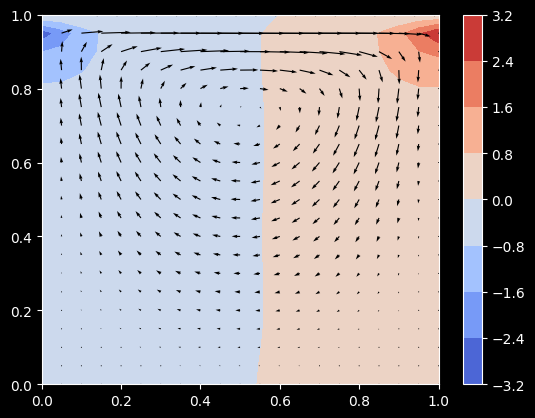

P_next typr:  <class 'numpy.ndarray'>
p_next shape:  (41, 41)
u_next typr:  <class 'numpy.ndarray'>
u_next shape:  (41, 41)
u_next[::2, ::2] typr:  <class 'numpy.ndarray'>
u_next[::2, ::2] shape:  (21, 21)
x typr:  <class 'numpy.ndarray'>
X shape:  (41, 41)


In [14]:
"""
Solves the incompressible Navier Stokes equations in a lid-driven cavity
scenario using Finite Differences, explicit timestepping and Chorin's Projection.

Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0


u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here =0)
ν:  Kinematic Viscosity
ρ:  Density
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator

----

Lid-Driven Cavity Scenario:


                            ------>>>>> u_top

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0

* Velocity and pressure have zero initial condition.
* Homogeneous Dirichlet Boundary Conditions everywhere except for horizontal
  velocity at top. It is driven by an external flow.

-----

Solution strategy:   (Projection Method: Chorin's Splitting)

1. Solve Momentum equation without pressure gradient for tentative velocity
   (with given Boundary Conditions)

    ∂u/∂t + (u ⋅ ∇) u = ν ∇²u

2. Solve pressure poisson equation for pressure at next point in time
   (with homogeneous Neumann Boundary Conditions everywhere except for
   the top, where it is homogeneous Dirichlet)

    ∇²p = ρ/Δt ∇ ⋅ u           

3. Correct the velocities (and again enforce the Velocity Boundary Conditions)

    u ← u − Δt/ρ ∇ p

-----

    Expected Outcome: After some time a swirling motion will take place

          1 +-------------------------------------------------+
            |                                                 |
            |                                                 |
            |                                                 |
        0.8 |                                                 |
            |                      *-->*                      |
            |                ******     ******                |
            |              **                 **              |
        0.6 |             *                     *             |
            |             *                      *            |
            |            *                        *           |
            |            *                       *            |
            |             *                     *             |
        0.4 |             *                     *             |
            |              **                 **              |
            |                ******     ******                |
            |                      *<--*                      |
        0.2 |                                                 |
            |                                                 |
            |                                                 |
            |                                                 |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

------

Strategy in index notation

u = [u, v]
x = [x, y]

1. Solve tentative velocity + velocity BC

    ∂u/∂t + u ∂u/∂x + v ∂u/∂y = ν ∂²u/∂x² + ν ∂²u/∂y²

    ∂v/∂t + u ∂v/∂x + v ∂v/∂y = ν ∂²v/∂x² + ν ∂²v/∂y²

2. Solve pressure poisson + pressure BC

    ∂²p/∂x² + ∂²p/∂y² = ρ/Δt (∂u/∂x + ∂v/∂y)

3. Correct velocity + velocity BC

    u ← u − Δt/ρ ∂p/∂x

    v ← v − Δt/ρ ∂p/∂y

------

IMPORTANT: Take care to select a timestep that ensures stability
"""

from tqdm import tqdm

N_POINTS = 41
DOMAIN_SIZE = 1.0
N_ITERATIONS = 500
TIME_STEP_LENGTH = 0.001
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1.0
HORIZONTAL_VELOCITY_TOP = 1.0

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5

def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    X, Y = np.meshgrid(x, y)

    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)


    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 2:  ]
            -
            f[1:-1, 0:-2]
        ) / (
            2 * element_length
        )
        return diff
    
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[2:  , 1:-1]
            -
            f[0:-2, 1:-1]
        ) / (
            2 * element_length
        )
        return diff
    
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2]
            +
            f[0:-2, 1:-1]
            -
            4
            *
            f[1:-1, 1:-1]
            +
            f[1:-1, 2:  ]
            +
            f[2:  , 1:-1]
        ) / (
            element_length**2
        )
        return diff
    

    maximum_possible_time_step_length = (
        0.5 * element_length**2 / KINEMATIC_VISCOSITY
    )
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_time_step_length:
        raise RuntimeError("Stability is not guarenteed")

    
    for _ in tqdm(range(N_ITERATIONS)):
        d_u_prev__d_x = central_difference_x(u_prev)
        d_u_prev__d_y = central_difference_y(u_prev)
        d_v_prev__d_x = central_difference_x(v_prev)
        d_v_prev__d_y = central_difference_y(v_prev)
        laplace__u_prev = laplace(u_prev)
        laplace__v_prev = laplace(v_prev)

        # Perform a tentative step by solving the momentum equation without the
        # pressure gradient
        u_tent = (
            u_prev
            +
            TIME_STEP_LENGTH * (
                -
                (
                    u_prev * d_u_prev__d_x
                    +
                    v_prev * d_u_prev__d_y
                )
                +
                KINEMATIC_VISCOSITY * laplace__u_prev
            )
        )
        v_tent = (
            v_prev
            +
            TIME_STEP_LENGTH * (
                -
                (
                    u_prev * d_v_prev__d_x
                    +
                    v_prev * d_v_prev__d_y
                )
                +
                KINEMATIC_VISCOSITY * laplace__v_prev
            )
        )

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_tent[0, :] = 0.0
        u_tent[:, 0] = 0.0
        u_tent[:, -1] = 0.0
        u_tent[-1, :] = HORIZONTAL_VELOCITY_TOP
        v_tent[0, :] = 0.0
        v_tent[:, 0] = 0.0
        v_tent[:, -1] = 0.0
        v_tent[-1, :] = 0.0


        d_u_tent__d_x = central_difference_x(u_tent)
        d_v_tent__d_y = central_difference_y(v_tent)

        # Compute a pressure correction by solving the pressure-poisson equation
        rhs = (
            DENSITY / TIME_STEP_LENGTH
            *
            (
                d_u_tent__d_x
                +
                d_v_tent__d_y
            )
        )

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = 1/4 * (
                +
                p_prev[1:-1, 0:-2]
                +
                p_prev[0:-2, 1:-1]
                +
                p_prev[1:-1, 2:  ]
                +
                p_prev[2:  , 1:-1]
                -
                element_length**2
                *
                rhs[1:-1, 1:-1]
            )

            # Pressure Boundary Conditions: Homogeneous Neumann Boundary
            # Conditions everywhere except for the top, where it is a
            # homogeneous Dirichlet BC
            p_next[:, -1] = p_next[:, -2]
            p_next[0,  :] = p_next[1,  :]
            p_next[:,  0] = p_next[:,  1]
            p_next[-1, :] = 0.0

            p_prev = p_next
        

        d_p_next__d_x = central_difference_x(p_next)
        d_p_next__d_y = central_difference_y(p_next)

        # Correct the velocities such that the fluid stays incompressible
        u_next = (
            u_tent
            -
            TIME_STEP_LENGTH / DENSITY
            *
            d_p_next__d_x
        )
        v_next = (
            v_tent
            -
            TIME_STEP_LENGTH / DENSITY
            *
            d_p_next__d_y
        )

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_next[0, :] = 0.0
        u_next[:, 0] = 0.0
        u_next[:, -1] = 0.0
        u_next[-1, :] = HORIZONTAL_VELOCITY_TOP
        v_next[0, :] = 0.0
        v_next[:, 0] = 0.0
        v_next[:, -1] = 0.0
        v_next[-1, :] = 0.0


        # Advance in time
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
    

    # The [::2, ::2] selects only every second entry (less cluttering plot)
    plt.style.use("dark_background")
    plt.figure()
    plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="coolwarm")
    plt.colorbar()

    plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    # plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()
    print("P_next typr: " , type(p_next))
    print("p_next shape: ", p_next.shape)
    print("u_next typr: " , type(u_next))
    print("u_next shape: ", u_next.shape)
    print("u_next[::2, ::2] typr: " , type(u_next[::2, ::2]))
    print("u_next[::2, ::2] shape: ", u_next[::2, ::2].shape)  
    print("x typr: " , type(X))
    print("X shape: ", X.shape)


if __name__ == "__main__":
    main()

In [ ]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
# PINNs compared to Numerical Solvers is garbage because high frequency data is not captured.
# CFD simulations are usually done in FORTRAN 